In [1]:
import pandas as pd
import numpy as np

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, classification_report, precision_score
from sklearn.preprocessing import scale

import statsmodels.api as sm
import statsmodels.formula.api as smf

# Visualisation libraries

## Text
from colorama import Fore, Back, Style
from IPython.display import display, Markdown, Latex

## seaborn
import seaborn as sns
sns.set_context("paper", rc={"font.size":12,"axes.titlesize":14,"axes.labelsize":12})
sns.set_style("whitegrid")

## matplotlib
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
plt.style.use('seaborn-whitegrid')
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12
plt.rcParams['text.color'] = 'k'
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

<div class="alert alert-block alert-info">
<font size="+2"><b>Default Dataset Example</b></font>
</div>

In this article, we demonstrate the concept of classification using the simulated Default dataset. This dataset can be extracted from the [**ISLR package**](https://cran.r-project.org/web/packages/ISLR/index.html) using the following syntax.

```R
library (ISLR)
write.csv(Default, "Default.csv")
```

We would like to predict whether an individual will default on his or her credit card payment, based on annual income and monthly credit card balance.

In [2]:
Default = pd.read_csv('Data/Default.csv', index_col = 0)
Default.columns = [x.title() for x in Default.columns]
Default.head(5)

Default Student      Balance        Income
1      No      No   729.526495  44361.625074
2      No     Yes   817.180407  12106.134700
3      No      No  1073.549164  31767.138947
4      No      No   529.250605  35704.493935
5      No      No   785.655883  38463.495879

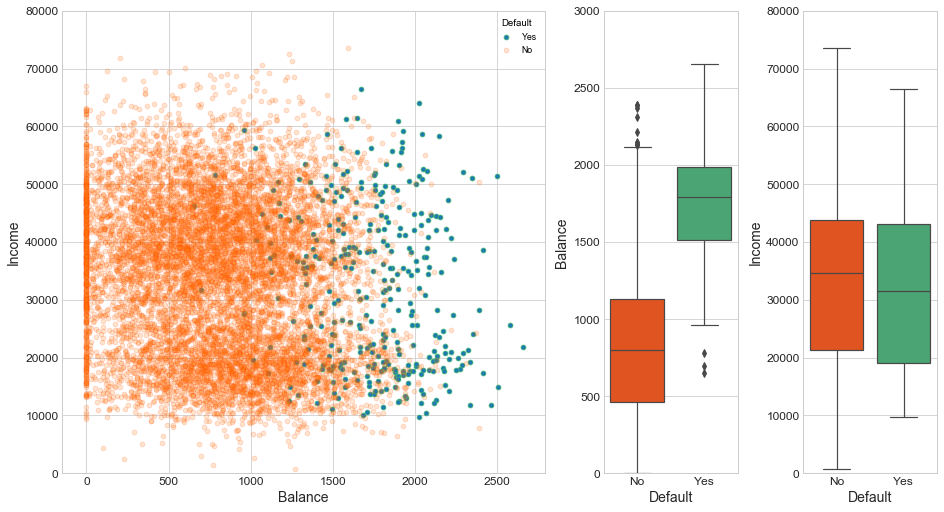

In [3]:
fig = plt.figure(figsize=(13,7), constrained_layout=True)
gs = fig.add_gridspec(1, 4)
ax0 = fig.add_subplot(gs[:2])
ax1 = fig.add_subplot(gs[2])
ax2 = fig.add_subplot(gs[3])

CP = {'Yes':'MediumSeaGreen', 'No':'OrangeRed'}
_ = ax0.scatter(Default.loc[Default.Default =='Yes', 'Balance'].values,
            Default.loc[Default.Default =='Yes', 'Income'].values, facecolors=None, edgecolors = CP['Yes'], label = 'Yes')
_ = ax0.scatter(Default.loc[Default.Default =='No', 'Balance'].values,
            Default.loc[Default.Default =='No', 'Income'].values, facecolors=None, edgecolors = CP['No'], label ='No',
                alpha = 0.2)

_ = ax0.set_ylim([0,8e4])
_ = ax0.set_xlabel('Balance')
_ = ax0.set_ylabel('Income')
_ = ax0.legend(title = 'Default', bbox_to_anchor=(1, 1))

_ = sns.boxplot('Default', 'Balance', data= Default, orient='v', ax=ax1, palette = CP)
_ = ax1.set_ylim([0,3e3])
_ = sns.boxplot('Default', 'Income', data= Default, orient='v', ax=ax2, palette = CP)
_ = ax2.set_ylim([0,8e4])

* **Left**: The annual incomes and monthly credit card balances of a number of individuals.
* **Center**: Boxplots of balance as a function of default status.
* **Right**: Boxplots of income as a function of default status.

# Logistic Regression


The linear regression in a binary response using multiple predictors:
$$\log\left(\frac{p(X)}{1 - p(X)}\right)= \beta_0 + \beta_1 X_1 + \dots + \beta_p X_p,$$
where $X= (X_1 ,...,X_p )$ are $p$ predictors. Here, the quantity $p(X)/[1−p(X)]$ is called **the odds**, and can take on any value odds between 0 and $\inf$.

The linear regression can be solved for $p(X)$,
$$p(X) =\dfrac{e^{\beta_0 +\beta_1 X_1 +\dots+\beta_p X_p}}{1 + e^{\beta_0 +\beta_1 X_1 +\dots+\beta_p X_p}}.$$

We can use the maximum likelihood method to estimate $\beta_j$ for $j=1,\ldots,p$. Logistic regression in python can be done using [**sklearn Logistic Regression**]( https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html).

First off, Student status can be encoded as a dummy variable as follows

$$\text{Student}=\begin{cases}
  1, & \mbox{Student},\\
  0, & \mbox{Non-Student}. \\
\end{cases}$$
This means

In [4]:
df = Default.copy()
df['Default'] = df.Default.factorize()[0]
df['Student'] = df.Student.factorize()[0]
df.head(5)

Default  Student      Balance        Income
1        0        0   729.526495  44361.625074
2        0        1   817.180407  12106.134700
3        0        0  1073.549164  31767.138947
4        0        0   529.250605  35704.493935
5        0        0   785.655883  38463.495879

For the Default data, logistic regression models the probability of default.
For example, the probability of default given balance can be written as
$$\mbox{Pr (Default = Yes | balance)}.$$

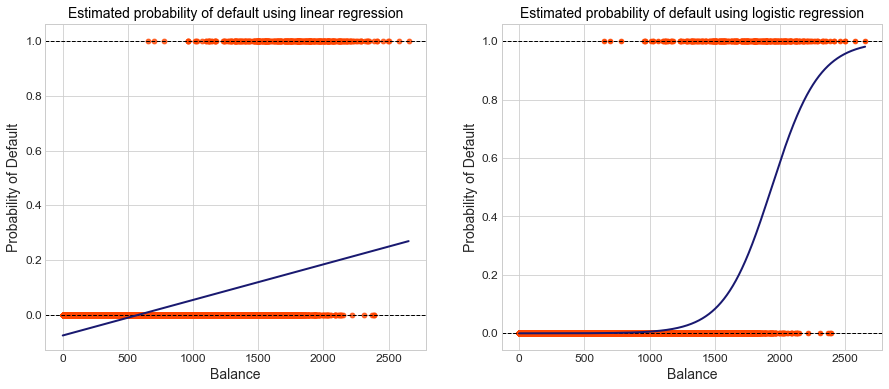

In [5]:
X_train = df['Balance'].values.reshape(-1,1)
y = df['Default'].values

# Generating test data
X_test = np.arange(df['Balance'].min(), Default['Balance'].max()).reshape(-1,1)

clf = LogisticRegression(solver='newton-cg')
_ = clf.fit(X_train,y)
Pred_Prop = clf.predict_proba(X_test)

fig, ax = plt.subplots(1, 2, figsize=(15,6))

# Left plot
_ = sns.regplot(X_train, y, order=1, ci=None, scatter_kws={'color':'OrangeRed'},
                line_kws={'color':'MidnightBlue', 'lw':2}, ax=ax[0])
Temp = ax[0].get_xlim()
_ = ax[0].hlines(0, Temp[0], Temp[1], linestyles='dashed', lw=1)
_ = ax[0].hlines(1, Temp[0], Temp[1], linestyles='dashed', lw=1)
_ = ax[0].set_xlim(Temp)
_ = ax[0].set_xlabel('Balance')
_ = ax[0].set_ylabel('Probability of Default')
_ = ax[0].set_title('Estimated probability of default using linear regression')
del Temp
#               xmax=ax.xaxis.get_data_interval()[1], linestyles='dashed', lw=1)
# Right plot
_ = ax[1].scatter(X_train, y, color='OrangeRed')
_ = ax[1].plot(X_test, Pred_Prop[:,1], color='MidnightBlue', lw = 2)
Temp = ax[1].get_xlim()
_ = ax[1].hlines(0, Temp[0], Temp[1], linestyles='dashed', lw=1)
_ = ax[1].hlines(1, Temp[0], Temp[1], linestyles='dashed', lw=1)
_ = ax[1].set_xlim(Temp)
_ = ax[1].set_xlabel('Balance')
_ = ax[1].set_ylabel('Probability of Default')
_ = ax[1].set_title('Estimated probability of default using logistic regression')
del Temp

We also could use [**Statsmodels Generalized Linear Models**](https://www.statsmodels.org/devel/examples/notebooks/generated/glm_formula.html). That is

In [6]:
model = smf.glm(formula = 'Default ~ Balance', data = df, family=sm.families.Binomial())
Results = model.fit()
Results.summary().tables[1]

<class 'statsmodels.iolib.table.SimpleTable'>

Now, let's try the following logistic regression

$$ \log \left( \frac{p(X)}{1-p(X)} \right) = \beta_0 +\beta_1 \times  \text{Student} +\beta_2 \times  \text{Balance} +\beta_3 \times  \text{Income}
 $$

The probability of default:

$$p(X) =\dfrac{e^{\beta_0 +\beta_1 \times  \text{Student} +\beta_2 \times  \text{Balance} +\beta_3 \times  \text{Income} }}
{1+e^{\beta_0 +\beta_1 \times  \text{Student} +\beta_2 \times  \text{Balance} +\beta_3 \times  \text{Income} }}.$$ 

In [7]:
formula = 'Default ~ Student + Income + Balance'
model = smf.glm(formula = formula, data=df, family=sm.families.Binomial())
Results = model.fit()
Results.summary().tables[1]

<class 'statsmodels.iolib.table.SimpleTable'>

For example, consider a student, James, with a credit card balance of $\$1,200$ and an income of $\$40,000$, and a non-student, Robert with the same balance and income. The estimated probability of defaults for these two:

In [8]:
df0=pd.DataFrame({'Student':[1,0],'Income':[40,40],'Balance':[1500,1500]},index=['James', 'Robert'])
df0

Student  Income  Balance
James         1      40     1500
Robert        0      40     1500

In [9]:
E=np.exp(Results.params['Intercept']+Results.params['Student']*df0['Student']\
+Results.params['Income']*df0['Income']+Results.params['Balance']*df0['Balance'])
P=E/(1+E)
pd.DataFrame(P,columns=['Probability of defaults'])

Probability of defaults
James                  0.051615
Robert                 0.094135

This shows that a student tends to have higher default probabilities than a non-student.

Now, consider

In [10]:
Group = Default.groupby(['Student','Default']).size().unstack('Default')
Group

Default    No  Yes
Student           
No       6850  206
Yes      2817  127

## Confounding
A confounder is a variable that influences both the dependent variable and the independent variable, causing an invalid association.

In [11]:
# Non-Students
X_train0 = df.loc[df.Student == 0, 'Balance'].values.reshape(-1,1)
y0 = df.loc[df.Student == 0, 'Default']
clf0 = LogisticRegression(solver='newton-cg')
_ = clf0.fit(X_train0, y0)

# Students
X_train1 = df.loc[df.Student == 1, 'Balance'].values.reshape(-1,1)
y1 = df.loc[df.Student == 1, 'Default']
clf1 = LogisticRegression(solver='newton-cg')
_ = clf1.fit(X_train1, y1)

X_test = np.arange(df['Balance'].min(), df['Balance'].max()).reshape(-1,1)

# Generating test data
Pred_Prob0 = clf0.predict_proba(X_test)
Pred_Prob1 = clf1.predict_proba(X_test)

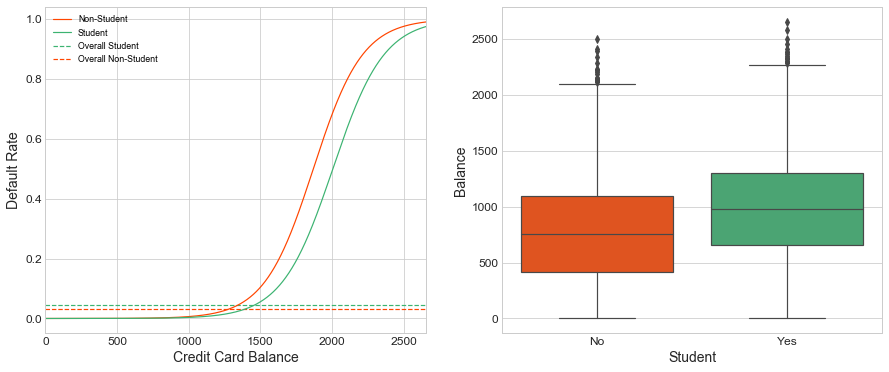

In [12]:
fig, ax = plt.subplots(1,2, figsize=(15,6))

# Left plot
# Non-Students
_ = ax[0].plot(X_test, Pred_Prob0[:,1], color= CP['No'], label='Non-Student')
# Studnets
_ = ax[0].plot(X_test, Pred_Prob1[:,1], color= CP['Yes'], label='Student')
Temp = ax[0].get_xlim()
# Overall Student
_ = ax[0].hlines(Group.loc['Yes','Yes']/Group.loc['Yes','No'], color= CP['Yes'], label='Overall Student',
                 xmin= Temp[0], xmax= Temp[1], linestyles='dashed')
_ = ax[0].hlines(Group.loc['No','Yes']/Group.loc['No','No'], color= CP['No'], label='Overall Non-Student',
                 xmin= Temp[0], xmax= Temp[1], linestyles='dashed')
_ = ax[0].set_ylabel('Default Rate')
_ = ax[0].set_xlabel('Credit Card Balance')
_ = ax[0].set_yticks(list(np.round(np.linspace(0,1,6),1)))
_ = ax[0].set_xlim(X_test.min(),X_test.max())
_ = ax[0].legend(loc=2)

# Right plot
_ = sns.boxplot('Student', 'Balance', data=Default, orient='v', ax=ax[1],  palette=CP)

We can see from the left-hand panel graph that students, on the whole, tend to have higher credit card balances means that overall, students tend to default at a higher rate than non-students even though an individual student with a given credit card balance will tend to have a lower probability of default than a non-student with the same credit card balance.

We can see from the left-hand panel graph that students are more likely to have large credit card balances and are associated with high default rates.

Students are generally riskier than non-students if no information about the student’s credit card balance is given. Nonetheless, that student is less risky than a non-student with the same credit card balance!

Correlation Matrix and plot:

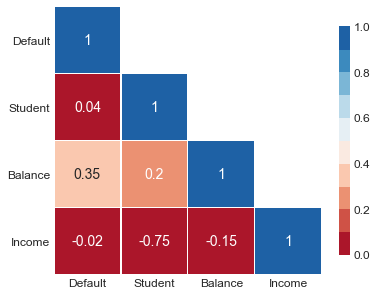

In [13]:
display(df.corr().style.background_gradient(cmap='RdBu').set_precision(2))

def Correlation_Plot (Df,Fig_Size):
    Correlation_Matrix = Df.corr().round(2)
    mask = np.zeros_like(Correlation_Matrix)
    mask[np.triu_indices_from(mask)] = True
    for i in range(len(mask)):
        mask[i,i]=0
    fig, ax = plt.subplots(figsize=(Fig_Size,Fig_Size))
    sns.heatmap(Correlation_Matrix, ax=ax, mask=mask, annot=True, square=True, 
                cmap =sns.color_palette("RdBu", n_colors=10), linewidths = 0.2, vmin=0, vmax=1,
                annot_kws={"size": 14}, cbar_kws={"shrink": .7})
    ax.set_yticklabels(ax.get_yticklabels(), rotation=0)
      
Correlation_Plot (df, 6)

As can be seen, the variables **Student** and **balance** are correlated and Students have higher values of depts, and the probability of default is higher for students.

***

## Refrences

* James, G., Witten, D., Hastie, T., & Tibshirani, R. (2013). [An introduction to statistical learning](https://link.springer.com/book/10.1007/978-1-4614-7138-7) (Vol. 112, pp. 3-7). New York: springer.

* Jordi Warmenhoven, [ISLR-python](https://github.com/JWarmenhoven/ISLR-python)
* James, G., Witten, D., Hastie, T., & Tibshirani, R. (2017). [ISLR: Data for an Introduction to Statistical Learning with Applications in R](https://cran.r-project.org/web/packages/ISLR/index.html)

***